In [13]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

import itertools
import time

### 1. Прочитайте базу my_PJME_MW.csv и сделайте ее перрасчет (ресемплинг) в представление по 1 месяцу.

In [5]:
my_PJME_MW = 'data/my_PJME_MW.csv'
data = pd.read_csv(my_PJME_MW, index_col=[0], parse_dates=[0])

In [6]:
data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [7]:
data_m = data.resample('M').mean()
data_m.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-31,31075.399731,2002.0,1.0,16.020188,1.0,16.020188,2.873486,2.905787,11.515478,0.063257,0.032301,0.064603
2002-02-28,30239.166667,2002.0,2.0,14.500000,1.0,45.500000,7.071429,3.000000,11.500000,0.035714,0.035714,0.035714
2002-03-31,28875.256720,2002.0,3.0,16.000000,1.0,75.000000,11.258065,3.193548,11.500000,0.000000,0.000000,0.000000
2002-04-30,28534.731572,2002.0,4.0,15.511822,2.0,105.511822,15.668985,2.828929,11.511822,0.000000,0.000000,0.000000
2002-05-31,28073.653226,2002.0,5.0,16.000000,2.0,136.000000,20.000000,3.000000,11.500000,0.032258,0.032258,0.032258


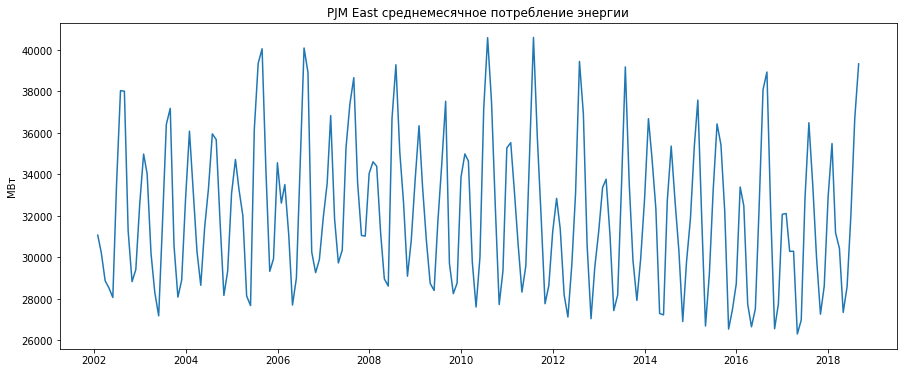

In [8]:
plt.figure(figsize =(15, 6))
plt.plot( data_m.index, data_m['PJME_MW'].values)
plt.title('PJM East среднемесячное потребление энергии')
plt.ylabel ('МВт');

### 2. Подберите параметры модели SARIMAX для этого ряда.

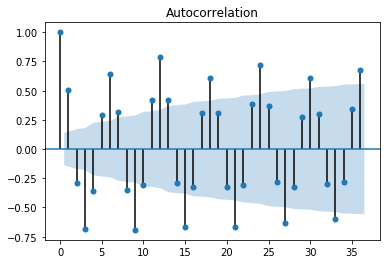

In [10]:
sm.graphics.tsa.plot_acf(data_m['PJME_MW'].values, lags=12*3)
plt.show()

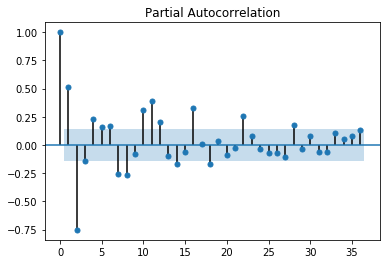

In [11]:
sm.graphics.tsa.plot_pacf(data_m['PJME_MW'].values, lags=12*3)
plt.show()

Наблюдается корреляция для квартальных лагов, самая большая корреляция между годовыми значениями, а для разностей важными являются значения внутри первых 3-х значений.

In [12]:
# Определим p, d и q в диапазоне 0-3
p = d = q = range(0, 3)

# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))

# зададим сезонность p, q и q
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            st_time = time.time()
            mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values,
                                    order=param,
                                    seasonal_order=param_seasonal ,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
            aic_ = 10000
            param_ = None 
            param_seasonal_ = None
            results = mod.fit()
            if results.aic < aic_:
                aic_ = results.aic
                param_ = param 
                param_seasonal_ = param_seasonal
            print('SARIMAX {} x {} - AIC: {} complete for {.3f} seconds'.format(param_, param_seasonal_, aic_, time.time() - st_time))
        except:
            continue
print()
print("Best params:")
print('SARIMAX {} x {} - AIC: {}'.format(param_, param_seasonal_, aic_))

SARIMAX (2, 2, 2) x (2, 2, 2, 12) - AIC: 2704.321616011388


In [19]:
mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values, 
                                order=param_,
                                seasonal_order=param_seasonal_,
                                enforce_stationarity= False,
                                enforce_invertibility=False)
results = mod.fit()

print(results.summary().tables[0], results.summary().tables[1])

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  200
Model:             SARIMAX(2, 2, 2)x(2, 2, 2, 12)   Log Likelihood               -1343.161
Date:                            Thu, 12 Dec 2019   AIC                           2704.322
Time:                                    14:40:32   BIC                           2731.236
Sample:                                         0   HQIC                          2715.257
                                            - 200                                         
Covariance Type:                              opg                                         
========================================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

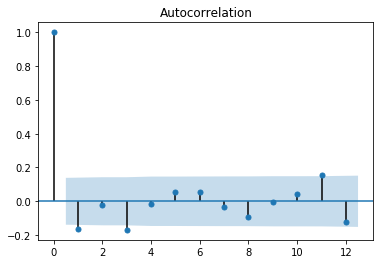

In [20]:
sm.graphics.tsa.plot_acf(results.resid, lags=12);

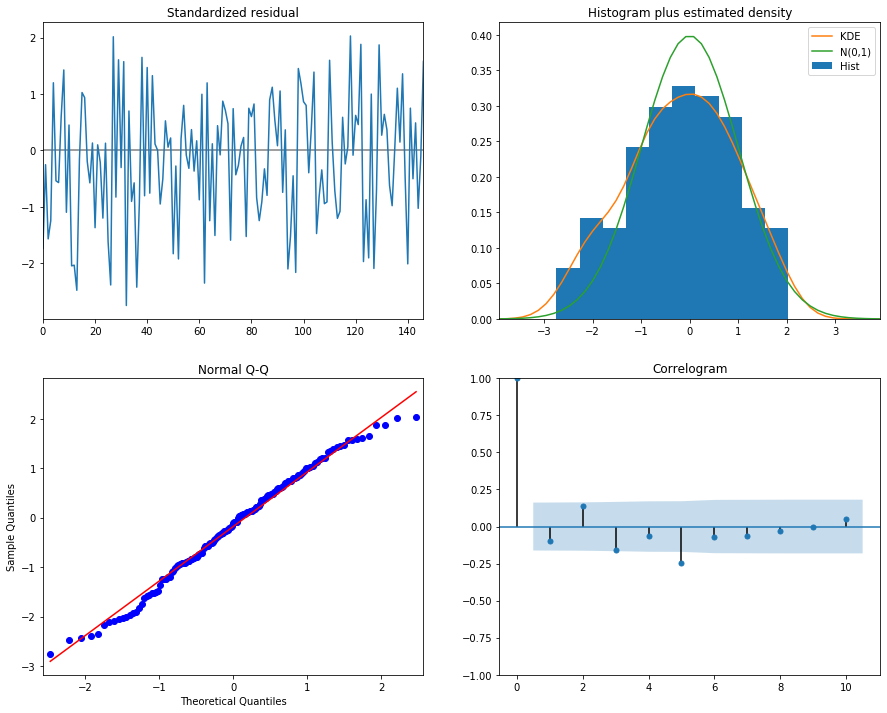

In [21]:
results.plot_diagnostics(figsize=(15, 12));

### 3. Сделайте вывод о том, как изменилась модель по сравнению с недельной.

Помесячная модель дает лучшие результаты по сравнению с недельной, скорее всего из за более показательных средних значений